## Convolutional Neural Network prototypes

Let's try using some basic CNN architectures to learn the categorization. We'll try a simple, fairly shallow network and a deeper, residual structure.

In [1]:
import datetime
import os
import logging
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers

import tools.train as train
import tools.models as models
import tools.plot as plot

## Read in data
files = ("../data/mitbih_train.csv", "../data/mitbih_test.csv")
inputs, labels, sparse_labels, df = train.preprocess(*files, fft=False)
# Add a dimension for "channels"
for key in inputs:
    inputs[key] = tf.expand_dims(inputs[key], axis=2)
train.class_count(df)


Train set
Count of each class
Classes
0.0    72471
1.0     2223
2.0     5788
3.0      641
4.0     6431
dtype: int64

Test set
Count of each class
Classes
0.0    18118
1.0      556
2.0     1448
3.0      162
4.0     1608
dtype: int64


### Small CNN

Here we'll try a relatively shallow architecture, with just a couple of convolutional layers and a fully connected layer at the end.

Model: "conv1d"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 187, 32)           128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 187, 64)           10304     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 93, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 93, 32)            6176      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 93, 64)            10304     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 23, 64)            0    

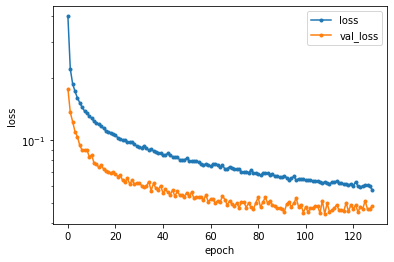

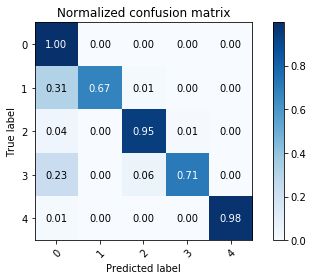

In [2]:
# Tensorboard logging
rightnow = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
nofftpath = os.path.join("..", "logs", rightnow, "nofft")

# Suppress tensorflow warnings about internal deprecations
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

config = {"optimizer": "Nadam",
          "loss": "categorical_crossentropy",
          "batch_size": 200,
          "val_split": 0.05,
          "epochs": 300,
          "verbose": 0,
          "patience": 20,
          "logdir": nofftpath}

layerlist = [
    ("conv", {"filters": 32, "width": 3}),
    ("conv", {"filters": 64, "width": 5}),
    ("maxpool", 2),
    ("conv", {"filters": 32, "width": 3}),
    ("conv", {"filters": 64, "width": 5}),
    ("maxpool", 4),
    (layers.Dropout(0.8,),),
]
inputsize = inputs["train"].shape[1]
ncategories = labels["train"].shape[1]
model = models.create_conv1d(inputsize, layerlist, ncategories)
history = train.train_print(model, inputs, labels, config)
plot.plot_fit_history(history)

test_pred = np.argmax(model.predict(inputs["test"]), axis=1)
plot.plot_cm(sparse_labels["test"], test_pred, classes=np.arange(5), normalize=True)

Let's try a deeper architecture, based loosely off of [WaveNet](https://arxiv.org/pdf/1609.03499.pdf):

Model: "conv1d"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 187, 32)      64          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 187, 32)      2080        conv1d_15[0][0]                  
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 187, 32)      2080        conv1d_15[0][0]                  
_____________________________________________________________________________________________

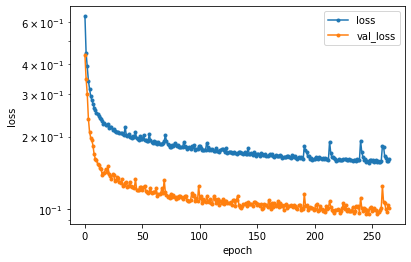

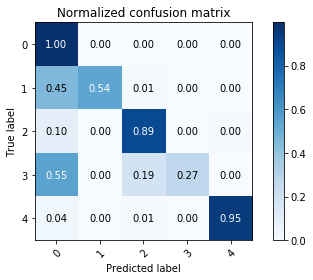

In [3]:
# Make the CNN, arbitrarily with four residual_blocks
nblocks = 4
nfilters = 32
dilation_limit = np.floor(inputs["train"].shape[1] / 2)

# Start
layerlist_res = [("conv", {"filters": nfilters, "width": 1, "padding": "causal"})]

# Residual blocks
models.add_res_blocks(nblocks, nfilters, dilation_limit, layerlist_res)

# End
layerlist_res.extend([
    (layers.Activation("relu"),),
    ("conv", {"filters": nfilters, "width": 1, "padding": "causal"}),
    ("conv", {"filters": 1, "width": 1, "padding": "causal"}),
    (layers.Dropout(0.8,),)
])

config = {"optimizer": "Nadam",
          "loss": "categorical_crossentropy",
          "batch_size": 200,
          "val_split": 0.05,
          "epochs": 300,
          "verbose": 0,
          "patience": 20,
          "logdir": nofftpath}

inputsize = inputs["train"].shape[1]
ncategories = labels["train"].shape[1]
model_res = models.create_conv1d(inputsize, layerlist_res, ncategories, config)
history = train.train_print(model_res, inputs, labels, config)
plot.plot_fit_history(history)

test_pred = np.argmax(model_res.predict(inputs["test"]), axis=1)
plot.plot_cm(sparse_labels["test"], test_pred, classes=np.arange(5), normalize=True)

We can see more overfitting occurring in the loss and validation loss plots; at the same time, the test accuracy is significantly better as well as the shape of the confusion matrix. Next up, maybe try some regularization, maybe with deeper architecture?